# Set things up

In [1]:
import os
import pandas as pd
import datetime
from sklearn.model_selection import StratifiedShuffleSplit

DATA_SOURCE = "C:/Users/sbranchett/Data/WiFi_data"
ACCESS_POINT = os.path.join(DATA_SOURCE, "WiFiAccessPoint.csv")

uni_hols = (datetime.date(year=2021, month=5, day=5),
            datetime.date(year=2021, month=5, day=13),
            datetime.date(year=2021, month=5, day=14),
            datetime.date(year=2021, month=5, day=24)
           )  # National Holidays and Collective Free days

def roster(date):
    # categorise the days of the academic year at TU Delft between 1 May 2021 and 29 August 2021
    
    if (date > datetime.date(year=2021, month=5, day=16)) and \
       (date < datetime.date(year=2021, month=5, day=22)):
        categorie = "Exam_BSc"
    elif (date > datetime.date(year=2021, month=6, day=15)) and \
         (date < datetime.date(year=2021, month=6, day=19)):
        categorie = "Study_mixed"
    elif (date > datetime.date(year=2021, month=6, day=22)) and \
         (date < datetime.date(year=2021, month=6, day=26)):
        categorie = "Exam_mixed"
    elif (date > datetime.date(year=2021, month=6, day=29)) and \
         (date < datetime.date(year=2021, month=7, day=3)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=8, day=8)) and \
         (date < datetime.date(year=2021, month=8, day=14)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=7, day=4)):
        categorie = "Free"
    else:
        categorie = "Learn"
    return categorie

# Get the interesting fields from the WiFi data

In [2]:
def load_wifi_data(interesting_columns, path=ACCESS_POINT):
    raw_data = pd.read_csv(path, delimiter=",")
    raw_data = raw_data.rename(columns=lambda x: x.strip())
    return raw_data[interesting_columns]

interesting_columns = ["timestamp", "clientCount", "locationHierarchy"]
all_data = load_wifi_data(interesting_columns)

# Extract Building

In [3]:
all_data["building"] = all_data["locationHierarchy"].str.split(" > ",expand=True)[1]

# Create five minute time buckets

In [4]:
# convert timestamp, given as Epoch in milliseconds, to datetime
all_data["datetime"] = all_data["timestamp"].apply(lambda d: datetime.datetime.fromtimestamp(int(d/1000)))

# separate out the date and the time in buckets of 5 minutes
all_data["date"] = all_data["datetime"].apply(lambda d: datetime.datetime.date(d))
all_data["time_5mins"] = all_data["datetime"].apply(lambda d: datetime.time(d.hour, 5*int(d.minute/5), 0))

# create datetime buckets of 5 minutes
all_data["bucket_5mins"] = all_data.apply(lambda row: datetime.datetime.combine(row["date"], row["time_5mins"]), axis=1)

# Bucketise clientCounts in five minute intervals, total per building

In [5]:
# Add up clientCounts for building / hour_bucket pair
all_data["time_building"] = all_data.apply(lambda row: str(row["bucket_5mins"]) + " _ " + str(row["building"]), axis=1)
bucket_data = all_data.groupby("time_building").sum().drop(columns=["timestamp"])

# Separate fields again
bucket_data['helper'] = bucket_data.index
bucket_data["bucket_datetime"] = bucket_data.apply(lambda row: datetime.datetime.fromisoformat(row["helper"][:19]), axis=1)
bucket_data["bucket_date"] = bucket_data.apply(lambda row: datetime.datetime.date(row["bucket_datetime"]), axis=1)
bucket_data["bucket_time"] = bucket_data.apply(lambda row: datetime.datetime.time(row["bucket_datetime"]), axis=1)
bucket_data["building"] = bucket_data.apply(lambda row: row["helper"][22:], axis=1)
bucket_data = bucket_data.drop(columns=["helper"])

# Create Work days and Student days

In [6]:
bucket_data["weekday"] = bucket_data.apply(lambda row: row["bucket_date"].weekday() < 5, axis=1)
bucket_data["uni_hols"] = bucket_data.apply(lambda row: row["bucket_date"].weekday() in uni_hols, axis=1)
bucket_data["academic_yr"] = bucket_data.apply(lambda row: roster(row["bucket_date"]), axis=1)
print(bucket_data)

                                             clientCount     bucket_datetime  \
time_building                                                                  
2021-05-14 13:30:00 _ 03-Science Center               34 2021-05-14 13:30:00   
2021-05-14 13:30:00 _ 05-TNW-BIO                       1 2021-05-14 13:30:00   
2021-05-14 13:30:00 _ 08-BK-City                       2 2021-05-14 13:30:00   
2021-05-14 13:30:00 _ 19-Studuitzendbureau            13 2021-05-14 13:30:00   
2021-05-14 13:30:00 _ 20-Aula                         32 2021-05-14 13:30:00   
...                                                  ...                 ...   
2021-05-21 16:50:00 _ 64-HSL                          10 2021-05-21 16:50:00   
2021-05-21 16:50:00 _ 66-Fellowship                  126 2021-05-21 16:50:00   
2021-05-21 16:50:00 _ Katalyse Labaratorium            8 2021-05-21 16:50:00   
2021-05-21 16:50:00 _ None                            32 2021-05-21 16:50:00   
2021-05-21 16:50:00 _ VLL-LAB(TNO)      

# Separate Test Set stratified over buildings

In [7]:
# get rid of rows with missing data
bucket_data = bucket_data.dropna()

# split has to have at least 2 rows with the same value
buildings = bucket_data["building"].value_counts()
to_drop = []
for index in buildings.index:
    if buildings[index] < 2:
        to_drop.append(index)
bucket_data = bucket_data[~bucket_data["building"].isin(to_drop)]

# indices need to be consecutive for split
bucket_data.index = range(len(bucket_data))

In [8]:
print(to_drop)

[]


In [9]:
# check all went well
#print('to_drop',to_drop)
print(bucket_data["building"].value_counts())

31-TBM                               2057
46-P E lab                           2057
43-EGM                               2057
38-Cultureel Centrum                 2057
28- WNI                              2057
05-TNW-BIO                           2057
22-TNW-TN                            2057
32-OCP-IO                            2057
36-ESP-Lab                           2057
26-Bouwcampus                        2057
08-BK-City                           2057
36-EWI LB_K t/m 3 & HB_K  t/m 2e     2057
62-LR                                2057
30-IKC_ISD-FMVG                      2057
VLL-LAB(TNO)                         2057
25-GreenVillage                      2057
21-BTUD                              2057
58-TNW-Zuid                          2057
45-LSL                               2057
66-Fellowship                        2057
50-TNW-RID                           2057
30-O S                               2057
36-EWI-HB                            2057
34-3ME                            

In [10]:
bucket_data.shape

(78166, 8)

<AxesSubplot:>

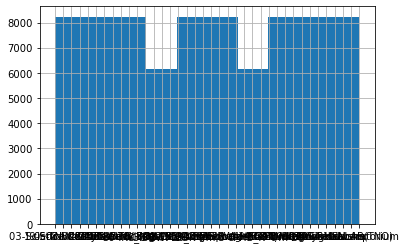

In [11]:
bucket_data["building"].hist()

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(bucket_data, bucket_data["building"]):
    strat_train_set = bucket_data.loc[train_index]
    strat_test_set = bucket_data.loc[test_index]

print(strat_train_set)

       clientCount     bucket_datetime bucket_date bucket_time  \
11688           15 2021-05-15 15:05:00  2021-05-15    15:05:00   
61351            1 2021-05-20 04:00:00  2021-05-20    04:00:00   
55780          101 2021-05-19 15:45:00  2021-05-19    15:45:00   
26158           12 2021-05-16 22:50:00  2021-05-16    22:50:00   
34879           16 2021-05-17 17:55:00  2021-05-17    17:55:00   
...            ...                 ...         ...         ...   
50892            4 2021-05-19 05:05:00  2021-05-19    05:05:00   
33498          247 2021-05-17 14:55:00  2021-05-17    14:55:00   
4160             2 2021-05-14 22:35:00  2021-05-14    22:35:00   
56082            8 2021-05-19 16:25:00  2021-05-19    16:25:00   
55786          670 2021-05-19 15:50:00  2021-05-19    15:50:00   

                                building  weekday  uni_hols academic_yr  
11688                    37-Sportcentrum    False     False       Learn  
61351                         36-ESP-Lab     True     False

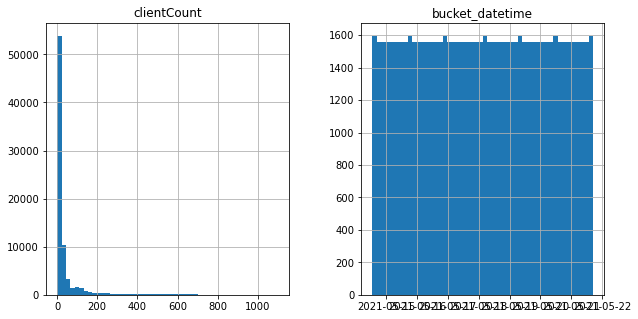

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
bucket_data.hist(bins=50, figsize=(10,5))
plt.show()

In [14]:
bucket_data.to_csv("bucket_data.csv")

In [15]:
strat_train_set.to_csv("strat_train_set.csv")
strat_test_set.to_csv("strat_test_set.csv")